In [12]:
import openai
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up OpenAI API
openai.api_key = ""

# Load train and test datasets
train_data = pd.read_csv("./data/train_no_window_proper_prompt.csv")
test_data = pd.read_csv("./data/test_no_window_proper_prompt.csv")

# Few-shot learning prompt template
# Focus examples:
# - Seek Strategy - So what should you do next?
# - Guiding Student - Can you calculate . . . ?
# - Recall Relevant Information - Can you reread the question and tell me what is . . . ?
# Probing examples:
# - Asking for Explanation - Why do you think you need to add these numbers?
# - Seeking Self Correction - Are you sure you need to add here?
# - Perturbing the Question - How would things change if they had . . . items instead?
# - Seeking World Knowledge - How do you calculate the perimeter of a square?
# Telling:
# - Revealing Strategy - You need to add . . . to . . . to get your answer.
# - Revealing Answer - No, he had . . . items.
# Generic examples:
# - Greeting/Fairwell - Hi . . . , how are you doing with the word problem?
# - General inquiry - Can you go walk me through your solution?

#Generate what a teacher should say right now and then name the strategy that generated answer responds to.
# Predict, what strategy out of these four: {labels}, is better to use for the teacher to answer to the last utterance. Use the description above to help you. Output only the name of the strategy.


prompt_template = """
{text}
Teacher: ({label})
"""



# Get unique labels from the train dataset
labels = train_data["label"].unique().tolist()

# Train the model using few-shot learning
def train_model(text, label):
    prompt = prompt_template.format(text=text, label=label)
    response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "system", "content": prompt}],
                temperature=0,
                max_tokens=512
            )
    return response.choices[0].message.content.strip()

In [13]:
# Make predictions on the test dataset
# test_data["predicted_label"] = test_data["text"].apply(train_model)
predicted_labels = []
for text, label in tqdm(zip(test_data["text"], test_data["label"])):
    predicted_labels.append(train_model(text, label))


845it [28:15,  2.01s/it]


RateLimitError: Rate limit reached for gpt-3.5-turbo in organization org-FxrAWsFfShXnkwK3xYLhJE2h on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.

In [ ]:
def write_utterances_to_file(utterances, filename):
    with open(filename, 'w') as file:
        for i, utterance in enumerate(utterances):
            file.write(f"{i}: {utterance}\n")

# File name to write the utterances to
filename = "predicted_answers_gold_label_proper_prompt.txt"

# Call the function to write utterances to the file
write_utterances_to_file(predicted_labels, filename)

print(f"Utterances have been written to '{filename}'.")

Utterances have been written to 'predicted_answers_no_label_proper_prompt.txt'.


In [ ]:
test_data["predicted_label"] = predicted_labels

In [ ]:
test_data["label"], test_data["predicted_label"]

(0         focus
 1       telling
 2       generic
 3         focus
 4         focus
          ...   
 3095    telling
 3096      focus
 3097      focus
 3098      focus
 3099    generic
 Name: label, Length: 3100, dtype: object,
 0       Hi Mariana, thank you for sharing your solutio...
 1       Good job on calculating the number of spoons J...
 2       Great job! You got it. Julia had a total of 15...
 3       Hi Ayisha, thank you for sharing your thought ...
 4       That's correct. Now, let's add this additional...
                               ...                        
 3095    Actually, the correct total amount of minutes ...
 3096    Thank you for sharing your solution. Let's go ...
 3097    That's correct. 225 cars have valid tickets. N...
 3098    That's correct. Now, can you calculate how man...
 3099    Great job! Your final answer of 30 cars withou...
 Name: predicted_label, Length: 3100, dtype: object)

Accuracy: 0.0


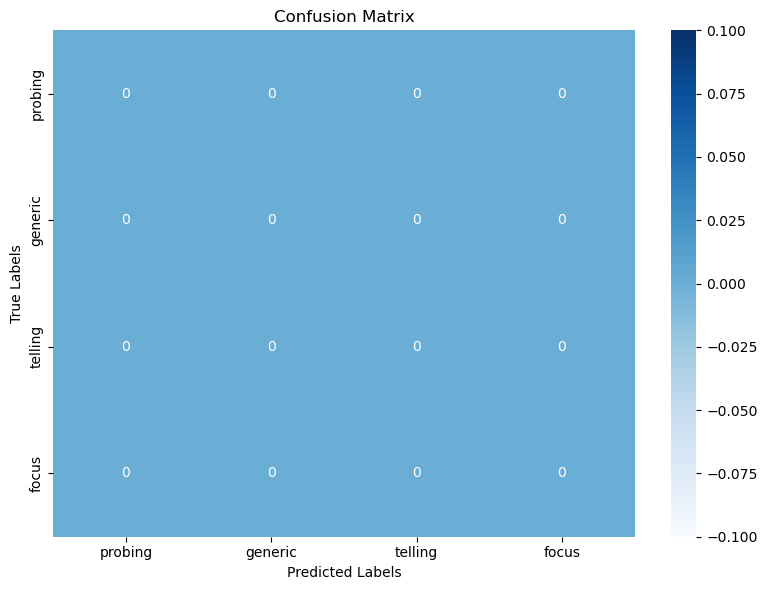

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(test_data["label"], test_data["predicted_label"])
print("Accuracy:", accuracy)

# Build confusion matrix
cm = confusion_matrix(test_data["label"], test_data["predicted_label"], labels=labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_json("./mathdial/output/chatgpt_baseline.jsonl", lines=True)

In [ ]:
print(data["conversation"][0])

Teacher: (generic)Hi , could you please walk me through your solution?|EOM|Student: Sure! I started by figuring out that one dozen is equal to 12, so two dozens is equal to 2 x 12 = 24 pens. Then, I figured out that half of a dozen is equal to 6, so half of 12 is equal to 6 and half of a dozen is equal to 6. After that, I calculated that one and a half dozen is equal to 1 x 12 + 6 = 18 pens. Finally, I added 24 + 18 to get the total of two and a half dozens of pens, which is equal to 42 pens.|EOM|Teacher: (telling)steven in the first two sentences of your solution, you have correctly calculated that 2 dozens is 24 and half dozen is 6. so one and a half dozen would simply mean adding these two. |EOM|Student: Oh, that makes sense. So one and a half dozen is equal to 24 + 6 = 30 pens. Then, two and a half dozen is equal to 24 + 18 = 42 pens.|EOM|Teacher: (telling)two and a half dozen is equal to 30. |EOM|Student: No, two and a half dozen is equal to 24 + 18 = 42 pens.|EOM|Teacher: (focus)

In [ ]:
data["chatgpt_baseline"][0]

"Roles.TEACHER: Hi Kayla! Could you walk me through your solution?<EOM>Roles.STUDENT: Sure! First, I know that one dozen is equal to 12 pens. So, two dozens would be 2 x 12 = 24 pens. Then, I remembered that half of a dozen is equal to 6 pens. So, half of 12 is 6 and half of a dozen is also 6. That means one and a half dozen is equal to 1 x 12 + 6 = 18 pens. Finally, I added 24 pens and 18 pens together to get a total of 42 pens. Did I miss anything?\\n\\nRoles.TEACHER: Great job explaining your steps, Kayla! Can you think of any other ways to solve this problem?\\n\\n\\nHmm, I could use a calculator to multiply 2 x 12 and add 1 x 12 + 6. That would give me the same answer of 42 pens. Is there another way to solve it?\\n\\nRoles.TEACHER: Yes, you could also think of it as 2.5 dozens, which is the same as 2 + 0.5 dozens. So, 2 x 12 = 24 pens and 0.5 x 12 = 6 pens. Adding those together gives us 30 pens. Then, we can multiply 0.5 x 12 again to get 6 more pens, giving us a total of 36 pen